# XGBOOST
@dottting @LuiseJedlitschka

This notebook demonstrates the workflow for building, tuning, and evaluating a XGBoost model for phage gene classification. We tried to optimize the model on the 80/20 split (we also tried other splits in the first stage of the model, but they pexgomed worse), through paramter tuning and feature importance analysis.
Underneath you can find code we used to analize and optimize the model. The content of the code cells is as follows:

1. Data loading of all test and train sets
2. basic methods to train a XGBoost model
3. method for fine tuning (Randomized Search, limited features)
4. feature analyzing methods
5. for-loop to let the tuned model perform on the splits
6. for-loop to let the basic model perform on the splits 

In [1]:
from pathlib import Path
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
import pickle
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier, plot_tree, to_graphviz
#import cupy as cp
from sklearn.utils.class_weight import compute_sample_weight
import time
import os
import seaborn as sns


In [2]:
# Load feature tables
test_path = Path("../data/leave-one-group-out-split/splits/").glob("test*.tsv")
train_path = Path("../data/leave-one-group-out-split/splits/").glob("train*.tsv")

test_tables = sorted(
    [(table.name, pd.read_csv(table, sep="\t")) for table in test_path]
)
train_tables = sorted(
    [(table.name, pd.read_csv(table, sep="\t")) for table in train_path]
)

# Do test and train match?
for i in range(0, 6):
    print(test_tables[i][0], train_tables[i][0])

test_dfs = [df for _, df in test_tables]
train_dfs = [df for _, df in train_tables]

stratified_test_path = "../data/combined-data-stratified-split/test_data.tsv"
stratified_train_path = "../data/combined-data-stratified-split/train_data.tsv"

test_dfs.append(pd.read_csv(stratified_test_path, sep="\t"))
train_dfs.append(pd.read_csv(stratified_train_path, sep="\t"))

test_split_0.tsv train_split_0.tsv
test_split_1.tsv train_split_1.tsv
test_split_2.tsv train_split_2.tsv
test_split_3.tsv train_split_3.tsv
test_split_4.tsv train_split_4.tsv
test_split_5.tsv train_split_5.tsv


In [3]:
def format_splits(train_df, test_df, split):
    le = LabelEncoder()
    le.fit(["early", "middle", "late"]) 
    train_df["classification_x"] = le.fit_transform(train_df["classification_x"])
    test_df["classification_x"] = le.fit_transform(test_df["classification_x"])

    ## Check to see if the encodings are consistent between test and train split
    # train_encodings = sorted(
    #     set(
    #         zip(
    #             train_df["classification_x"],
    #             le.inverse_transform(train_df["classification_x"]),
    #         )
    #     )
    # )
    # test_encodings = sorted(
    #     set(
    #         zip(
    #             test_df["classification_x"],
    #             le.inverse_transform(test_df["classification_x"]),
    #         )
    #     )
    # )

    # print("Train encodings:")
    # for enc, label in train_encodings:
    #     print(f"{enc}: {label}")

    # print("\nTest encodings:")
    # for enc, label in test_encodings:
    #     print(f"{enc}: {label}")

    # if train_encodings != test_encodings:
    #     print("! Encodings do not match")

    # Select feature columns
    drop_cols = ["Unnamed: 0", "Geneid", "DNASequence", "classification_x"]

    if "group" in train_df.columns:
        drop_cols.append("group")

    feature_cols = train_df.drop(columns=drop_cols).columns

    X_train = train_df[feature_cols].copy()
    y_train = train_df["classification_x"].copy()

    X_test = test_df[feature_cols].copy()
    y_test = test_df["classification_x"].copy()

    result = (X_train, y_train, X_test, y_test, le, split)
    
    # save split data as pickle
    filepath = "../data/xgboost/"
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(f"../data/xgboost/split_{split}_data.pkl", "wb") as f:
        pickle.dump(result, f)
    

    return result

def run_xgboost(X_train, y_train, X_test, y_test, le, split):
    bst = XGBClassifier(objective="binary:logistic", seed=42)
    # fit model
    bst.fit(X_train, y_train)

    # save model
    joblib.dump(bst, f"../data/xgboost/model_split_{split}.joblib")

    # determine 80 most important features
    importances = bst.feature_importances_
    feature_names = X_train.columns
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top80_features = feat_imp.index[:80].tolist()
    print("Top 80 Features:", top80_features)

    # Print confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            bst, X_test, y_test, display_labels=le.classes_, normalize=normalize
        )
        disp.ax_.set_title(f"{title}, Split {split}")

        print(title)
        print(disp.confusion_matrix)

    plt.show()

In [4]:
# analyzing feature relevance
def on_best_features(X_train, y_train, X_test, y_test, le, split):
    # train only on best features
    top_features = [
    'GC_Content', 'C_Content', 'kmer_TTG', 'kmer_TGA', 'kmer_TTT', 'kmer_CTG', 'kmer_GCT', 'CpG_bias',
    'kmer_AAT', 'kmer_ATA', 'Gene_Position_Relative', 'Seq_length', 'kmer_GAG', 'kmer_AAG', 'kmer_AGG',
    'A_Content', 'kmer_CCG', 'motive_PolyA_signal_rel', 'kmer_CCC', 'kmer_CCT', 'C_frac', 'kmer_GGA',
    'kmer_CTT', 'molecular_weight', 'kmer_CAA', 'kmer_GCC', 'T_Content', 'aromaticity', 'kmer_TCA',
    'frac_exposed', 'kmer_CTA', 'kmer_TCT', 'kmer_GTA', 'kmer_GTT', 'kmer_ACA', 'kmer_TGT', 'kmer_GGC',
    'kmer_ACG'
    ]

    # Reduce datasets to top features only
    X_train = X_train[top_features]
    X_test = X_test[top_features]
    return X_train, y_train, X_test, y_test, le, split

def show_feature_relevance(xg_model, X_train):
    # Visualize feature importances (after training!)
    if hasattr(xg_model, 'feature_importances_'):
        importances = xg_model.feature_importances_
        feature_names = X_train.columns
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
        plt.title('Top 30 Feature Importances (XGBoost)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print('Feature importances not available for this model.')

In [7]:
def tune_model(X_train, y_train, X_test, y_test, le, split):
    ## Train model
    start_time = time.time()

    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

    param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11],
    "learning_rate": [0.3, 0.1, 0.05, 0.01, 0.005],
    "gamma": [0, 0.1, 0.25, 0.5, 1.0],
    "reg_lambda": [0, 0.1, 1, 5, 10, 20],
    "reg_alpha": [0, 0.1, 1, 5, 10, 20],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    }

    optimal_params = RandomizedSearchCV(
        estimator=XGBClassifier(
            objective="multi:softprob",
            num_class=3,
            seed=42,
            subsample=0.9,
            colsample_bytree=0.5,
            device="cuda",
        ),
        param_distributions=param_grid,
        scoring="roc_auc_ovr",
        n_iter=20,
        cv=3,
        n_jobs=10,
    )

    # Evaluate model
    optimal_params.fit(X_train, y_train)  # , sample_weight=sample_weights)

    print(optimal_params.best_params_)
    # {"reg_lambda": 1.0, "max_depth": 4, "learning_rate": 0.1, "gamma": 0}

    end_time = time.time()
    elapsed_time = end_time - start_time

    xg_optimized = optimal_params.best_estimator_
    y_pred = xg_optimized.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["early", "late", "middle"]))
    cv_scores = cross_val_score(xg_optimized, X_train, y_train, cv=5, scoring='accuracy')
    print("CV-Score (mean):", cv_scores.mean())
    print("CV-Scores (per fold):", cv_scores)

    ConfusionMatrixDisplay.from_estimator(xg_optimized, X_test, y_test)
    plt.title(f"Confusion Matrix for Split {split}")
    plt.tight_layout()
    plt.show()

    bt = xg_optimized.get_booster()
    for importance_type in ("weight", "total_gain", "total_cover", "gain", "cover"):
        print("%s: " % importance_type, bt.get_score(importance_type=importance_type))

    show_feature_relevance(xg_optimized, X_train)

    node_params = {"shape": "box", "style": "filled, rounded", "fillcolor": "#78cbef"}
    leaf_params = {"shape": "box", "style": "filled", "fillcolor": "#e48038"}

    # save model
    joblib.dump(xg_optimized, f"../data/xgboost/model_split_{split}.joblib")

    # save pickle
    result = (X_train, y_train, X_test, y_test, le, split)
    filepath = "../data/xgboost/"
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(f"../data/xgboost/split_{split}_data.pkl", "wb") as f:
        pickle.dump(result, f)

    #to_graphviz(
    #    xg_optimized,
    #    tree_idx=0,
    #    size="10,10",
    #    condition_node_params=node_params,
    #    leaf_node_params=leaf_params,
    #)

Split 0


c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:50] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 20, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

       early       0.17      0.33      0.22         3
        late       0.90      0.28      0.43        32
      middle       0.37      0.74      0.49        19

    accuracy                           0.44        54
   macro avg       0.48      0.45      0.38        54
weighted avg       0.67      0.44      0.44        54



c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:51] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:51] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:51] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:52] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:1

CV-Score (mean): 0.4590909090909091
CV-Scores (per fold): [0.32727273 0.58181818 0.52272727 0.39545455 0.46818182]


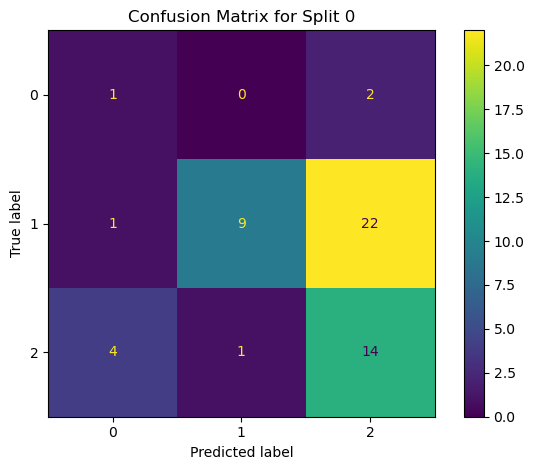

weight:  {'Gene_Position_Relative': 71.0, 'GC_Content': 17.0, 'Seq_length': 35.0, 'A_Content': 13.0, 'T_Content': 9.0, 'G_Content': 13.0, 'C_Content': 26.0, 'Purin_Content': 6.0, 'Pyrimidin_Content': 3.0, 'CpG_bias': 21.0, 'motive_TATA_box_rel': 16.0, 'motive_PolyA_signal_rel': 6.0, 'kmer_AAA': 27.0, 'kmer_AAT': 23.0, 'kmer_AAG': 10.0, 'kmer_AAC': 22.0, 'kmer_ATA': 22.0, 'kmer_ATT': 10.0, 'kmer_ATG': 11.0, 'kmer_ATC': 9.0, 'kmer_AGA': 17.0, 'kmer_AGT': 12.0, 'kmer_AGG': 8.0, 'kmer_AGC': 12.0, 'kmer_ACA': 29.0, 'kmer_ACT': 12.0, 'kmer_ACG': 6.0, 'kmer_ACC': 7.0, 'kmer_TAA': 15.0, 'kmer_TAT': 5.0, 'kmer_TAG': 20.0, 'kmer_TAC': 14.0, 'kmer_TTA': 21.0, 'kmer_TTT': 14.0, 'kmer_TTG': 22.0, 'kmer_TTC': 21.0, 'kmer_TGA': 31.0, 'kmer_TGT': 23.0, 'kmer_TGG': 11.0, 'kmer_TGC': 22.0, 'kmer_TCA': 12.0, 'kmer_TCT': 23.0, 'kmer_TCG': 10.0, 'kmer_TCC': 12.0, 'kmer_GAA': 12.0, 'kmer_GAT': 25.0, 'kmer_GAG': 20.0, 'kmer_GAC': 11.0, 'kmer_GTA': 21.0, 'kmer_GTT': 18.0, 'kmer_GTG': 9.0, 'kmer_GTC': 5.0, 'km

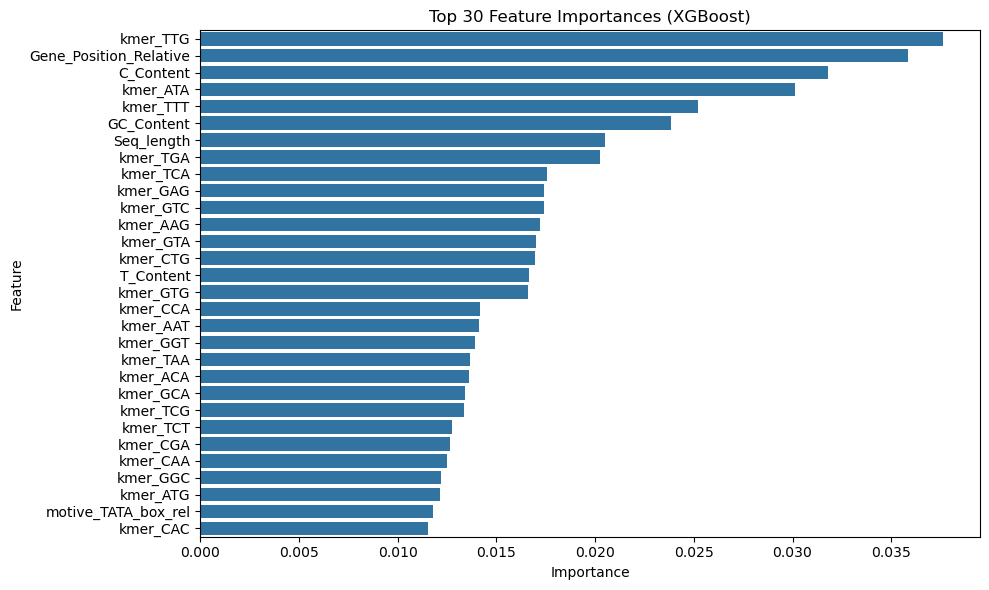

Split 1


c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:18] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

       early       0.48      0.13      0.20        78
        late       0.33      0.88      0.48        59
      middle       0.28      0.17      0.21       100

    accuracy                           0.33       237
   macro avg       0.36      0.39      0.30       237
weighted avg       0.36      0.33      0.28       237



c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:18] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:19] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:19] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:20] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:1

CV-Score (mean): 0.5123366595390829
CV-Scores (per fold): [0.47826087 0.73369565 0.45355191 0.3989071  0.49726776]


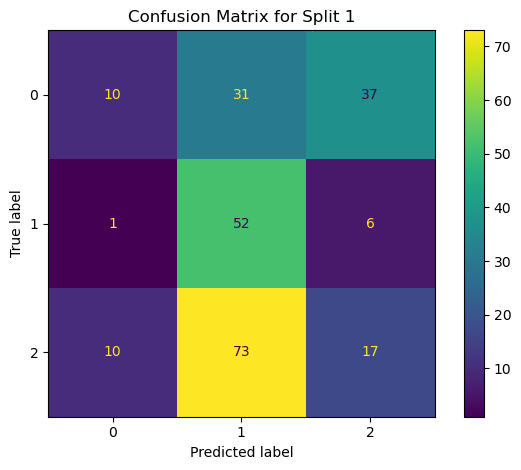

weight:  {'Gene_Position_Relative': 213.0, 'GC_Content': 27.0, 'Seq_length': 98.0, 'A_Content': 36.0, 'T_Content': 27.0, 'G_Content': 28.0, 'C_Content': 18.0, 'Purin_Content': 26.0, 'Pyrimidin_Content': 17.0, 'CpG_bias': 35.0, 'motive_TATA_box_rel': 30.0, 'motive_PolyA_signal_rel': 17.0, 'kmer_AAA': 60.0, 'kmer_AAT': 44.0, 'kmer_AAG': 31.0, 'kmer_AAC': 37.0, 'kmer_ATA': 65.0, 'kmer_ATT': 21.0, 'kmer_ATG': 32.0, 'kmer_ATC': 21.0, 'kmer_AGA': 54.0, 'kmer_AGT': 27.0, 'kmer_AGG': 24.0, 'kmer_AGC': 16.0, 'kmer_ACA': 58.0, 'kmer_ACT': 33.0, 'kmer_ACG': 24.0, 'kmer_ACC': 10.0, 'kmer_TAA': 23.0, 'kmer_TAT': 35.0, 'kmer_TAG': 35.0, 'kmer_TAC': 38.0, 'kmer_TTA': 33.0, 'kmer_TTT': 41.0, 'kmer_TTG': 66.0, 'kmer_TTC': 57.0, 'kmer_TGA': 80.0, 'kmer_TGT': 48.0, 'kmer_TGG': 20.0, 'kmer_TGC': 35.0, 'kmer_TCA': 44.0, 'kmer_TCT': 32.0, 'kmer_TCG': 15.0, 'kmer_TCC': 23.0, 'kmer_GAA': 36.0, 'kmer_GAT': 34.0, 'kmer_GAG': 30.0, 'kmer_GAC': 25.0, 'kmer_GTA': 41.0, 'kmer_GTT': 36.0, 'kmer_GTG': 35.0, 'kmer_GTC

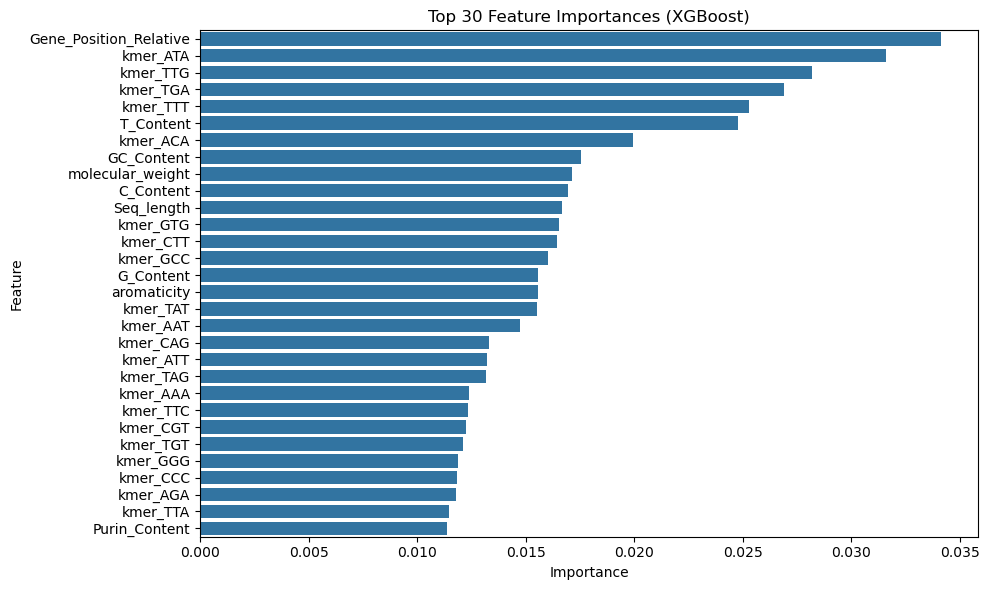

Split 2


c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:39] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.7}
              precision    recall  f1-score   support

       early       0.75      0.09      0.16       162
        late       0.48      0.65      0.55       117
      middle       0.05      0.56      0.08         9

    accuracy                           0.33       288
   macro avg       0.42      0.43      0.27       288
weighted avg       0.62      0.33      0.32       288



c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:39] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:40] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:41] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:42] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:1

CV-Score (mean): 0.4688392797820743
CV-Scores (per fold): [0.45402299 0.41618497 0.56069364 0.40462428 0.50867052]


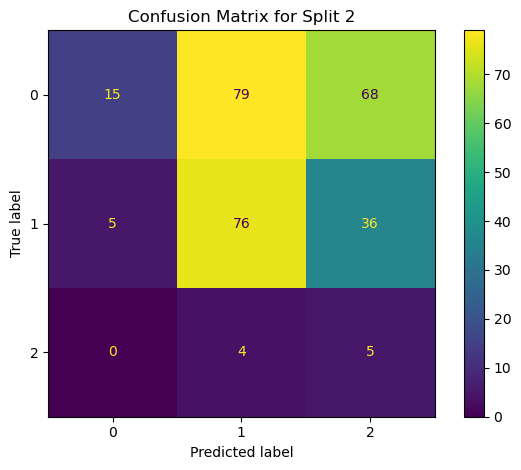

weight:  {'Gene_Position_Relative': 441.0, 'GC_Content': 35.0, 'Seq_length': 83.0, 'A_Content': 55.0, 'T_Content': 34.0, 'G_Content': 43.0, 'C_Content': 48.0, 'Purin_Content': 45.0, 'Pyrimidin_Content': 16.0, 'CpG_bias': 72.0, 'motive_TATA_box_rel': 22.0, 'motive_PolyA_signal_rel': 22.0, 'kmer_AAA': 65.0, 'kmer_AAT': 51.0, 'kmer_AAG': 53.0, 'kmer_AAC': 60.0, 'kmer_ATA': 49.0, 'kmer_ATT': 59.0, 'kmer_ATG': 79.0, 'kmer_ATC': 49.0, 'kmer_AGA': 51.0, 'kmer_AGT': 50.0, 'kmer_AGG': 59.0, 'kmer_AGC': 38.0, 'kmer_ACA': 63.0, 'kmer_ACT': 73.0, 'kmer_ACG': 45.0, 'kmer_ACC': 49.0, 'kmer_TAA': 59.0, 'kmer_TAT': 27.0, 'kmer_TAG': 43.0, 'kmer_TAC': 48.0, 'kmer_TTA': 59.0, 'kmer_TTT': 50.0, 'kmer_TTG': 60.0, 'kmer_TTC': 67.0, 'kmer_TGA': 65.0, 'kmer_TGT': 67.0, 'kmer_TGG': 37.0, 'kmer_TGC': 48.0, 'kmer_TCA': 53.0, 'kmer_TCT': 95.0, 'kmer_TCG': 38.0, 'kmer_TCC': 44.0, 'kmer_GAA': 47.0, 'kmer_GAT': 65.0, 'kmer_GAG': 74.0, 'kmer_GAC': 46.0, 'kmer_GTA': 37.0, 'kmer_GTT': 58.0, 'kmer_GTG': 52.0, 'kmer_GTC

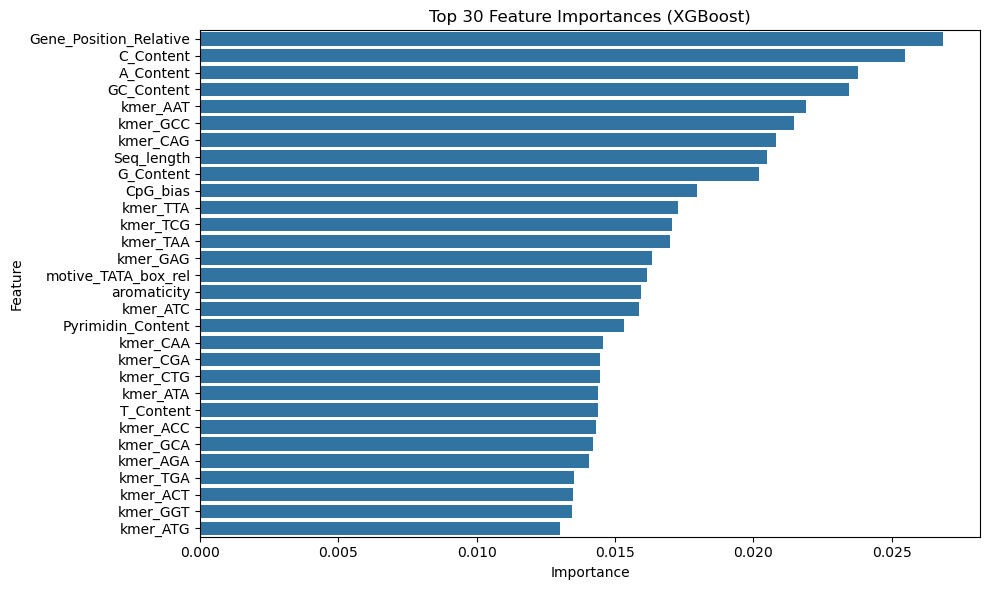

Split 3


c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:09] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.7, 'reg_lambda': 20, 'reg_alpha': 20, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

       early       0.33      0.14      0.20         7
        late       0.35      0.95      0.51        21
      middle       0.00      0.00      0.00        32

    accuracy                           0.35        60
   macro avg       0.23      0.37      0.24        60
weighted avg       0.16      0.35      0.20        60



c:\Users\luise\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luise\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luise\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luise\anaconda3\Lib\site-packag

CV-Score (mean): 0.5055799924594696
CV-Scores (per fold): [0.47488584 0.56164384 0.5890411  0.29223744 0.61009174]


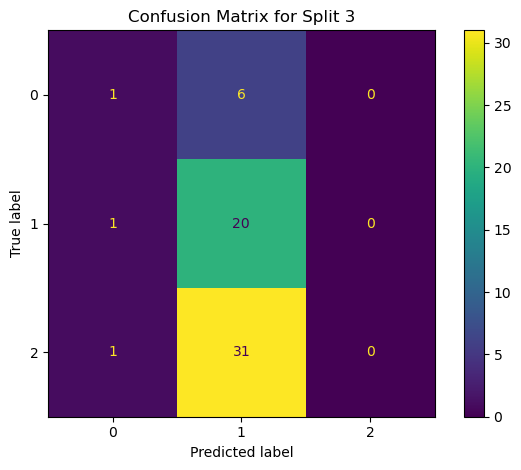

weight:  {'Gene_Position_Relative': 191.0, 'GC_Content': 63.0, 'Seq_length': 58.0, 'A_Content': 10.0, 'T_Content': 21.0, 'G_Content': 28.0, 'C_Content': 76.0, 'Purin_Content': 2.0, 'Pyrimidin_Content': 5.0, 'CpG_bias': 10.0, 'motive_TATA_box_rel': 3.0, 'motive_PolyA_signal_rel': 1.0, 'kmer_AAA': 23.0, 'kmer_AAT': 18.0, 'kmer_AAG': 7.0, 'kmer_AAC': 1.0, 'kmer_ATA': 48.0, 'kmer_ATT': 1.0, 'kmer_ATG': 17.0, 'kmer_ATC': 3.0, 'kmer_AGA': 4.0, 'kmer_AGT': 2.0, 'kmer_AGG': 7.0, 'kmer_ACA': 51.0, 'kmer_ACG': 4.0, 'kmer_ACC': 8.0, 'kmer_TAA': 6.0, 'kmer_TAT': 16.0, 'kmer_TAG': 3.0, 'kmer_TAC': 8.0, 'kmer_TTA': 2.0, 'kmer_TTT': 28.0, 'kmer_TTG': 65.0, 'kmer_TTC': 15.0, 'kmer_TGA': 71.0, 'kmer_TGT': 6.0, 'kmer_TGG': 5.0, 'kmer_TGC': 7.0, 'kmer_TCA': 2.0, 'kmer_TCT': 30.0, 'kmer_TCG': 6.0, 'kmer_TCC': 4.0, 'kmer_GAA': 5.0, 'kmer_GAT': 3.0, 'kmer_GAG': 8.0, 'kmer_GAC': 1.0, 'kmer_GTA': 38.0, 'kmer_GTT': 36.0, 'kmer_GTG': 10.0, 'kmer_GGG': 6.0, 'kmer_GGC': 4.0, 'kmer_GCA': 18.0, 'kmer_GCT': 1.0, 'km

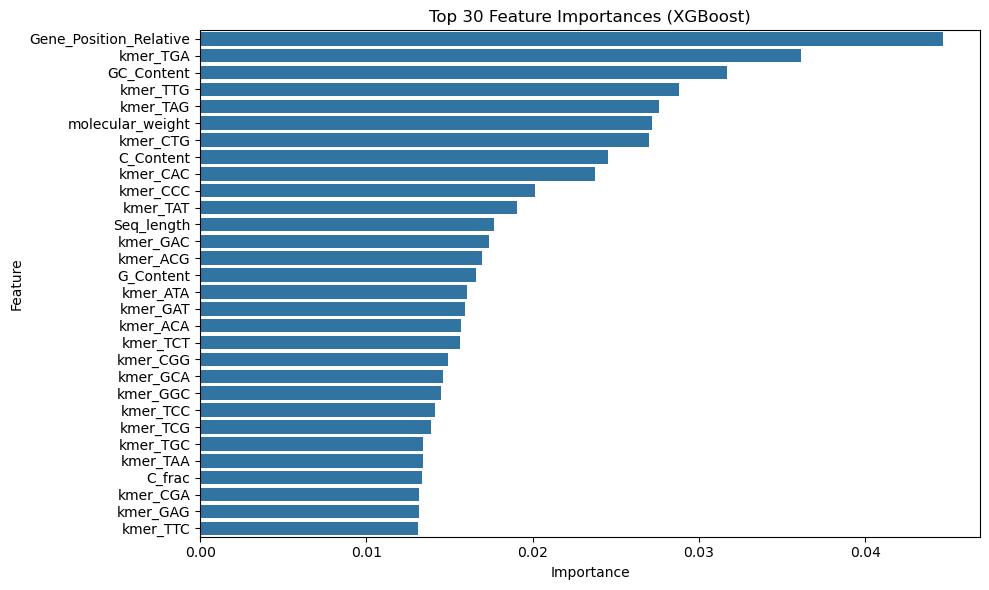

Split 4


c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:33] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.5, 'colsample_bytree': 0.9}
              precision    recall  f1-score   support

       early       0.15      0.74      0.25        46
        late       0.74      0.72      0.73       209
      middle       0.50      0.07      0.12       206

    accuracy                           0.43       461
   macro avg       0.46      0.51      0.36       461
weighted avg       0.57      0.43      0.41       461



c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:33] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:34] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:34] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:35] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:1

CV-Score (mean): 0.5351996663538734
CV-Scores (per fold): [0.65467626 0.50359712 0.55395683 0.49275362 0.47101449]


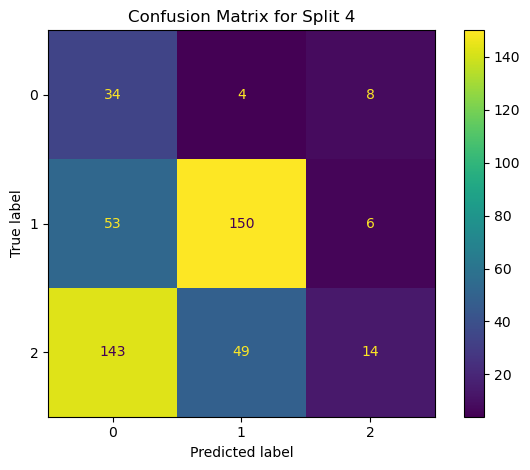

weight:  {'Gene_Position_Relative': 116.0, 'GC_Content': 9.0, 'Seq_length': 26.0, 'A_Content': 9.0, 'T_Content': 10.0, 'G_Content': 16.0, 'C_Content': 16.0, 'Purin_Content': 5.0, 'Pyrimidin_Content': 2.0, 'CpG_bias': 14.0, 'motive_TATA_box_rel': 8.0, 'motive_PolyA_signal_rel': 10.0, 'kmer_AAA': 13.0, 'kmer_AAT': 23.0, 'kmer_AAG': 17.0, 'kmer_AAC': 7.0, 'kmer_ATA': 9.0, 'kmer_ATT': 15.0, 'kmer_ATG': 14.0, 'kmer_ATC': 18.0, 'kmer_AGA': 16.0, 'kmer_AGT': 23.0, 'kmer_AGG': 20.0, 'kmer_AGC': 11.0, 'kmer_ACA': 20.0, 'kmer_ACT': 19.0, 'kmer_ACG': 10.0, 'kmer_ACC': 12.0, 'kmer_TAA': 14.0, 'kmer_TAT': 12.0, 'kmer_TAG': 11.0, 'kmer_TAC': 11.0, 'kmer_TTA': 14.0, 'kmer_TTT': 18.0, 'kmer_TTG': 17.0, 'kmer_TTC': 10.0, 'kmer_TGA': 18.0, 'kmer_TGT': 24.0, 'kmer_TGG': 19.0, 'kmer_TGC': 19.0, 'kmer_TCA': 11.0, 'kmer_TCT': 25.0, 'kmer_TCG': 7.0, 'kmer_TCC': 11.0, 'kmer_GAA': 7.0, 'kmer_GAT': 15.0, 'kmer_GAG': 26.0, 'kmer_GAC': 11.0, 'kmer_GTA': 15.0, 'kmer_GTT': 13.0, 'kmer_GTG': 16.0, 'kmer_GTC': 18.0, 

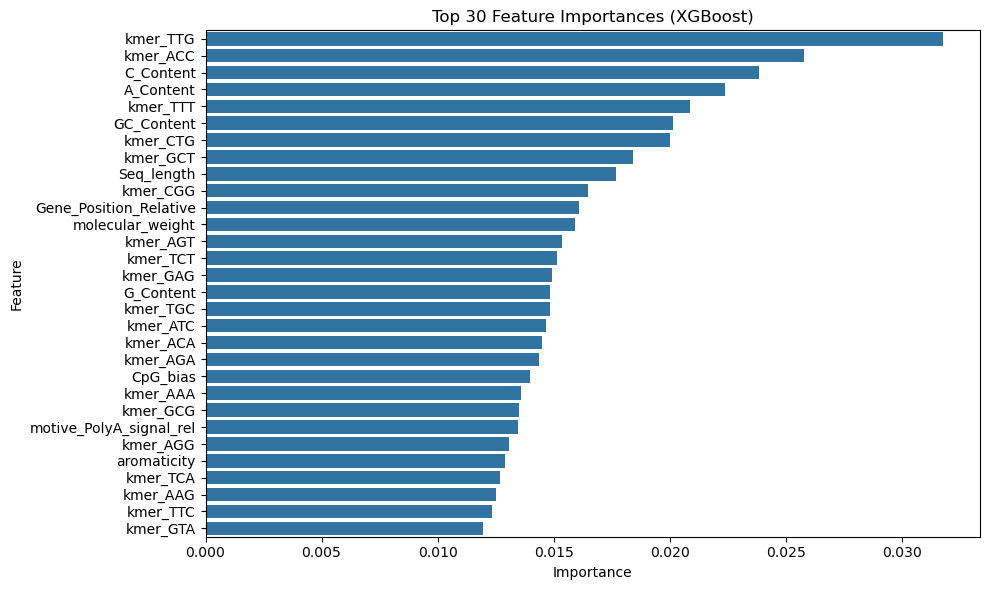

Split 5


c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:03] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 20, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

       early       0.50      0.78      0.61         9
        late       0.61      0.83      0.70        23
      middle       0.56      0.23      0.32        22

    accuracy                           0.57        54
   macro avg       0.56      0.61      0.54        54
weighted avg       0.57      0.57      0.53        54



c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:03] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:03] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:04] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:04] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:1

CV-Score (mean): 0.5063636363636363
CV-Scores (per fold): [0.47272727 0.55       0.61363636 0.32272727 0.57272727]


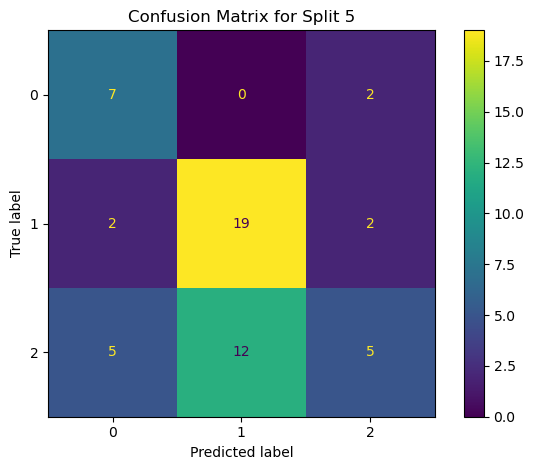

weight:  {'Gene_Position_Relative': 99.0, 'GC_Content': 18.0, 'Seq_length': 32.0, 'A_Content': 9.0, 'T_Content': 10.0, 'G_Content': 15.0, 'C_Content': 25.0, 'Purin_Content': 4.0, 'Pyrimidin_Content': 1.0, 'CpG_bias': 13.0, 'motive_TATA_box_rel': 9.0, 'motive_PolyA_signal_rel': 4.0, 'kmer_AAA': 18.0, 'kmer_AAT': 19.0, 'kmer_AAG': 5.0, 'kmer_AAC': 7.0, 'kmer_ATA': 24.0, 'kmer_ATT': 6.0, 'kmer_ATG': 12.0, 'kmer_ATC': 6.0, 'kmer_AGA': 18.0, 'kmer_AGT': 8.0, 'kmer_AGG': 8.0, 'kmer_AGC': 4.0, 'kmer_ACA': 33.0, 'kmer_ACT': 12.0, 'kmer_ACG': 5.0, 'kmer_ACC': 6.0, 'kmer_TAA': 6.0, 'kmer_TAT': 7.0, 'kmer_TAG': 8.0, 'kmer_TAC': 10.0, 'kmer_TTA': 7.0, 'kmer_TTT': 10.0, 'kmer_TTG': 39.0, 'kmer_TTC': 24.0, 'kmer_TGA': 34.0, 'kmer_TGT': 9.0, 'kmer_TGG': 4.0, 'kmer_TGC': 12.0, 'kmer_TCA': 7.0, 'kmer_TCT': 23.0, 'kmer_TCG': 1.0, 'kmer_TCC': 6.0, 'kmer_GAA': 17.0, 'kmer_GAT': 6.0, 'kmer_GAG': 8.0, 'kmer_GAC': 8.0, 'kmer_GTA': 25.0, 'kmer_GTT': 14.0, 'kmer_GTG': 6.0, 'kmer_GTC': 7.0, 'kmer_GGA': 2.0, 'km

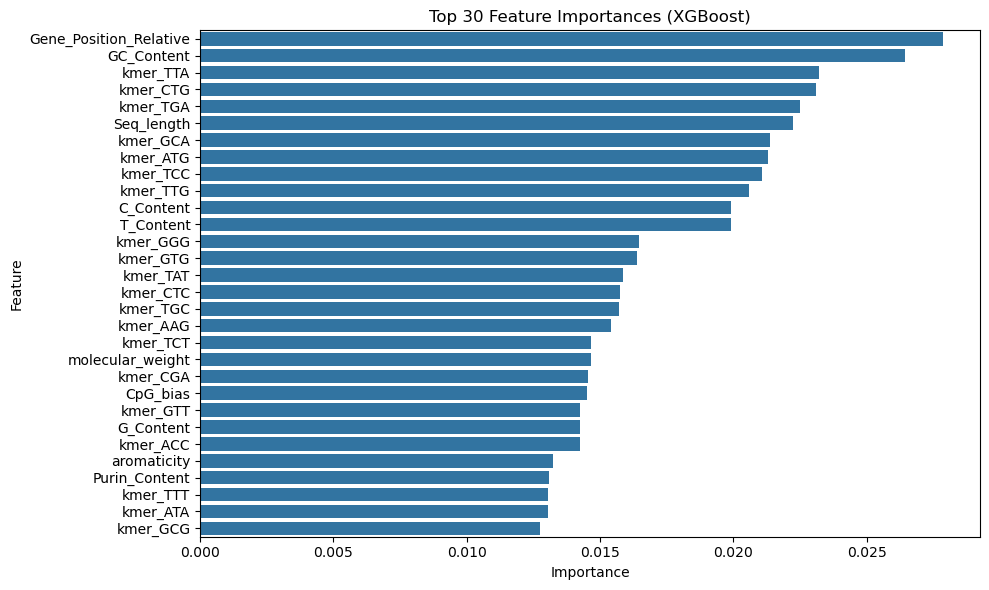

stratified Split


c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:13] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 9, 'learning_rate': 0.005, 'gamma': 1.0, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

       early       0.71      0.69      0.70        61
        late       0.72      0.78      0.75        92
      middle       0.68      0.63      0.65        78

    accuracy                           0.71       231
   macro avg       0.70      0.70      0.70       231
weighted avg       0.70      0.71      0.70       231



c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:14] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:14] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:15] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:16] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:1

CV-Score (mean): 0.6706815511163338
CV-Scores (per fold): [0.69189189 0.62702703 0.65405405 0.64673913 0.73369565]


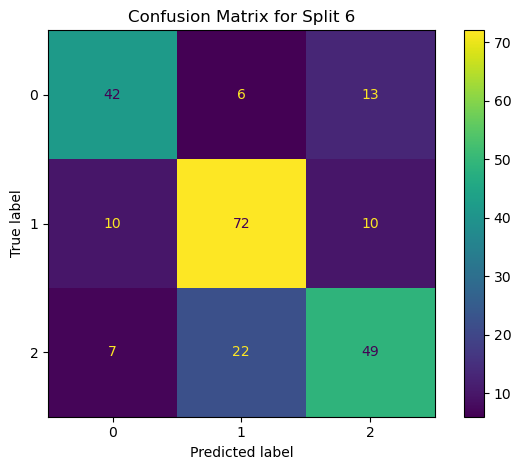

weight:  {'GC_Content': 399.0, 'C_Content': 376.0, 'kmer_TTG': 454.0, 'kmer_TGA': 522.0, 'kmer_TTT': 325.0, 'kmer_CTG': 372.0, 'kmer_GCT': 309.0, 'CpG_bias': 371.0, 'kmer_AAT': 286.0, 'kmer_ATA': 372.0, 'Gene_Position_Relative': 1119.0, 'Seq_length': 388.0, 'kmer_GAG': 326.0, 'kmer_AAG': 334.0, 'kmer_AGG': 360.0, 'A_Content': 286.0, 'kmer_CCG': 197.0, 'motive_PolyA_signal_rel': 175.0, 'kmer_CCC': 170.0, 'kmer_CCT': 251.0, 'C_frac': 356.0, 'kmer_GGA': 273.0, 'kmer_CTT': 290.0, 'molecular_weight': 259.0, 'kmer_CAA': 380.0, 'kmer_GCC': 176.0, 'T_Content': 323.0, 'aromaticity': 347.0, 'kmer_TCA': 323.0, 'frac_exposed': 297.0, 'kmer_CTA': 304.0, 'kmer_TCT': 356.0, 'kmer_GTA': 316.0, 'kmer_GTT': 347.0, 'kmer_ACA': 407.0, 'kmer_TGT': 300.0, 'kmer_GGC': 220.0, 'kmer_ACG': 270.0}
total_gain:  {'GC_Content': 2116.814453125, 'C_Content': 1524.7239990234375, 'kmer_TTG': 2433.728271484375, 'kmer_TGA': 2292.73193359375, 'kmer_TTT': 1238.7220458984375, 'kmer_CTG': 1401.299560546875, 'kmer_GCT': 905.9

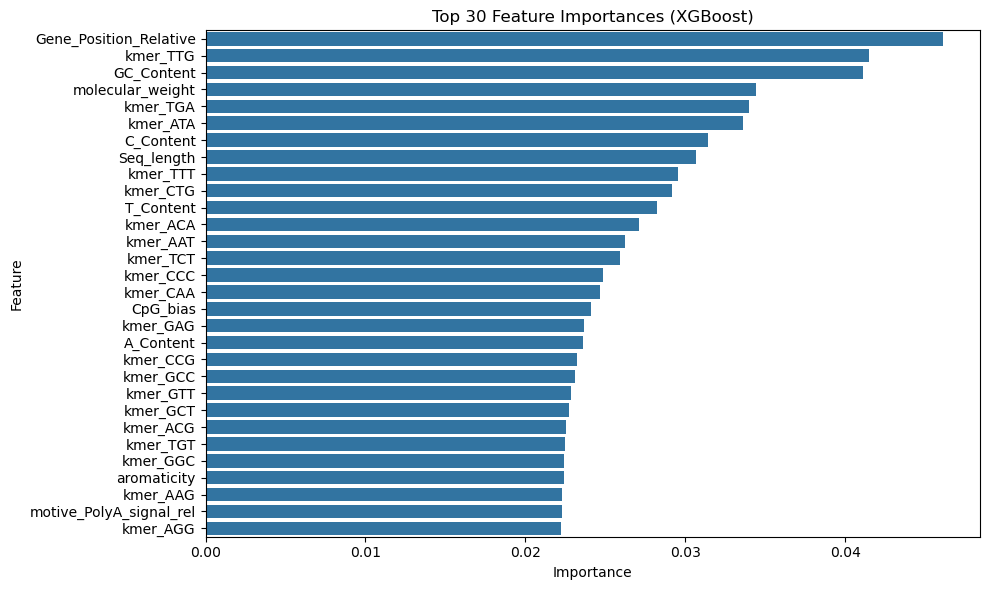

In [8]:
# run fine tuning
for i, (train_df, test_df) in enumerate(zip(train_dfs, test_dfs)):
    if i == 6: 
        print("stratified Split")
        top_features = on_best_features(*format_splits(train_df, test_df, i))
        tune_model(*top_features)

    else:
        print(f"Split {i}")
        tune_model(*format_splits(train_df, test_df, i))

Spalten in train_df (0): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

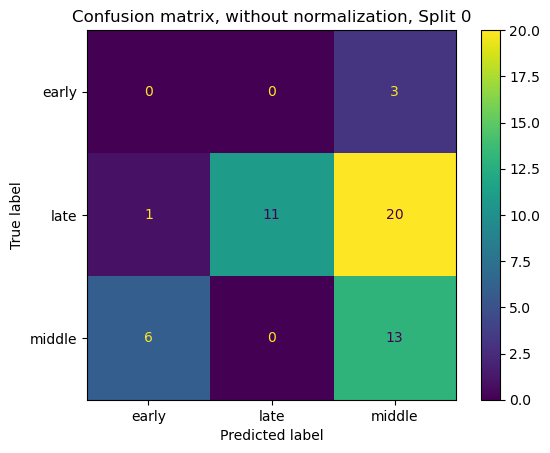

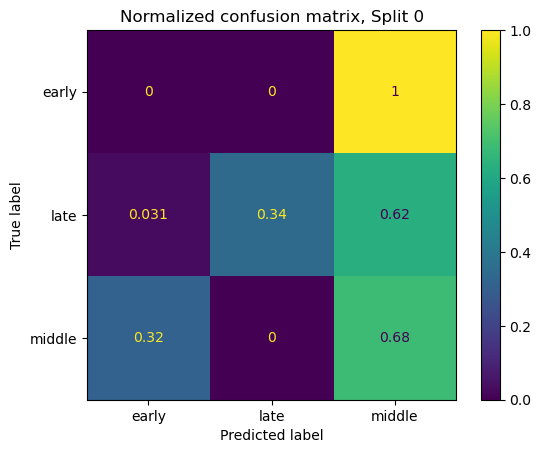

Spalten in train_df (1): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

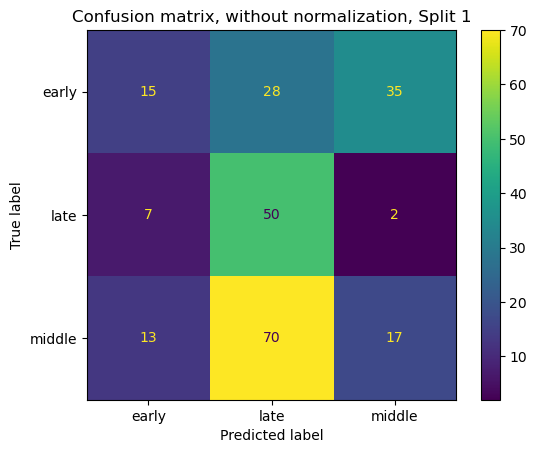

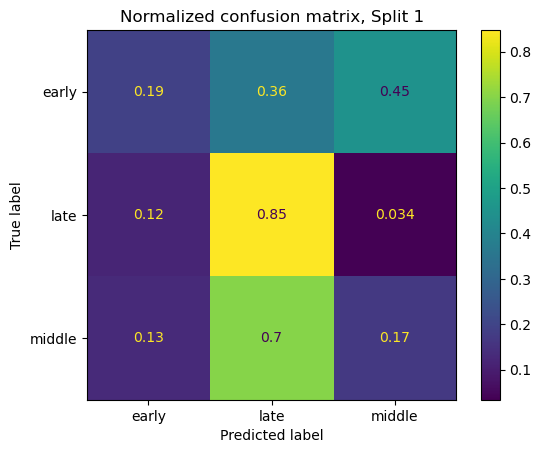

Spalten in train_df (2): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

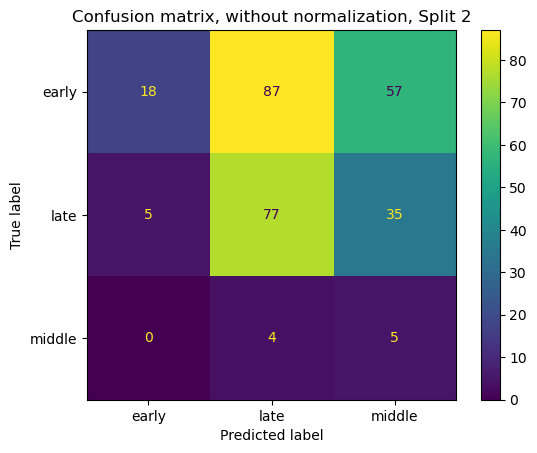

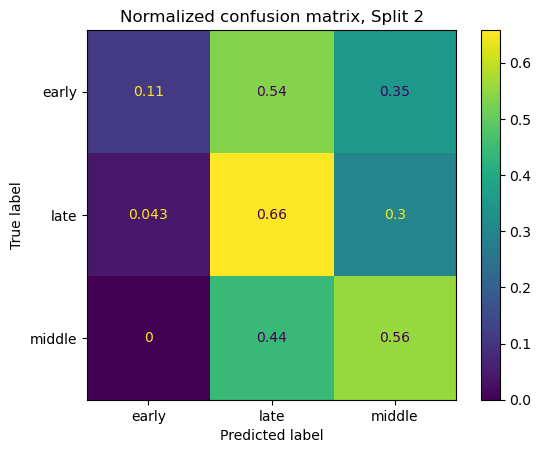

Spalten in train_df (3): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

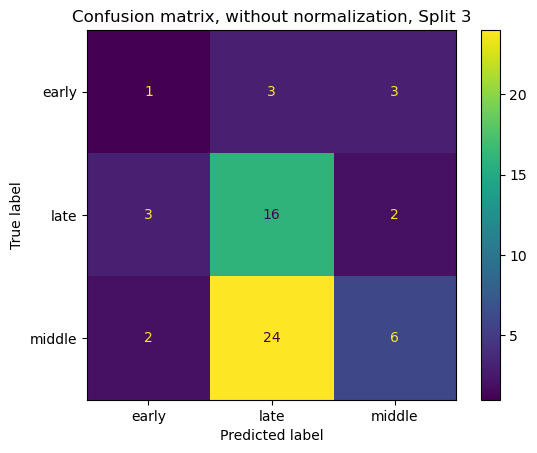

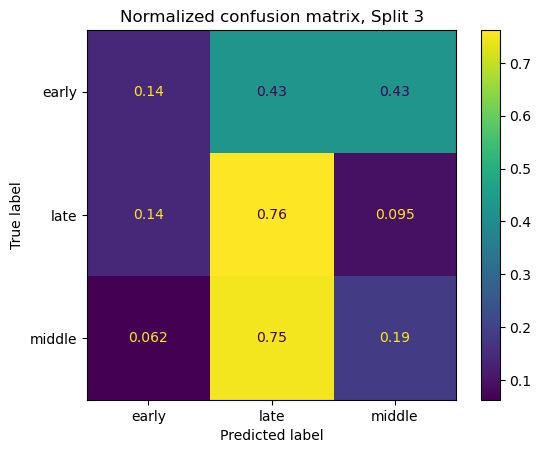

Spalten in train_df (4): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

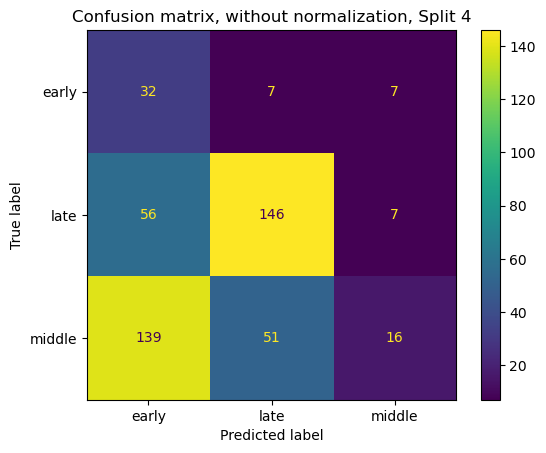

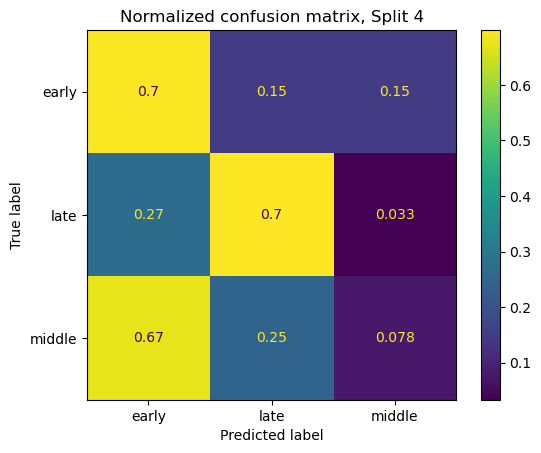

Spalten in train_df (5): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

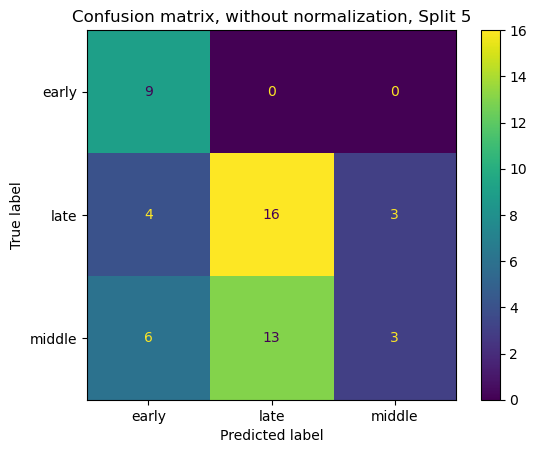

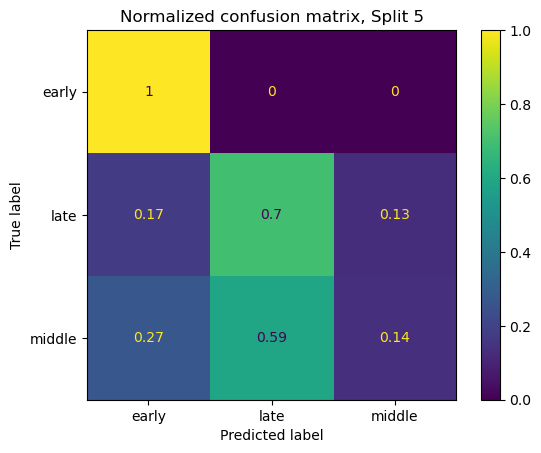

Spalten in train_df (6): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

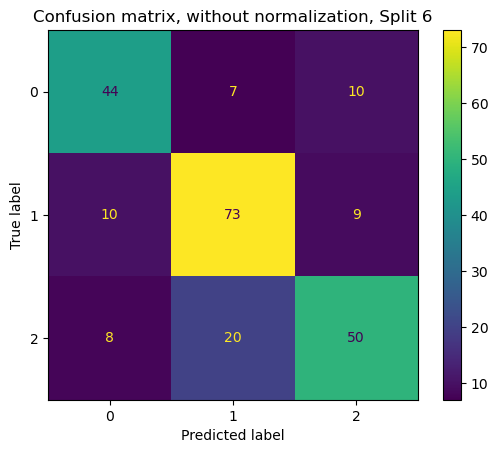

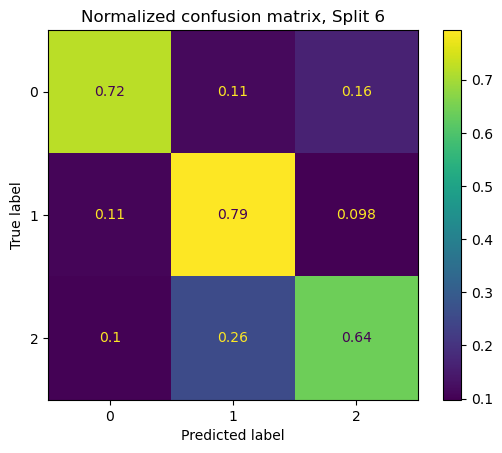

In [129]:
# run basic xgboost
for i, (train_df, test_df) in enumerate(zip(train_dfs, test_dfs)):
    print(f"Spalten in train_df ({i}):", train_df.columns.tolist())
    print(f"Spalten in test_df ({i}):", test_df.columns.tolist())

    if i == 6: 
        print("stratified Split")
        run_xgboost(*format_splits(train_df, test_df, i))

    else:
        print(f"Split {i}")
        run_xgboost(*format_splits(train_df, test_df, i))
